In [18]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import numpy as np
import healpy as hp
from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import pickle
import corner
import os

from scipy import optimize
from scipy.stats import poisson

import jax
import jax.numpy as jnp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../utils/matplotlibrc')

from utils import ed_fcts as ef

In [19]:
# load SVI fit results (these should be the only parameters that you are loading)
gpu_id = '0'

# name of the synthetic directory
sim_name = 'canon_g1_ola'

# load SVI fit results (these should be the only parameters that you are loading)
sim_id = 7.1234567
temp_id = 5.23457
gp_id = 1.16
blg_id = -1
mod_id = 120
svi_id = 25
sim_seed = 1000
svi_seed = 0

In [20]:
# load GPU
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

data_dir = ef.load_data_dir(sim_name)
os.system("mkdir -p "+data_dir)

# Load the simulated templates
## NOTE: This information should already be taken into account once
## specifying the relevant IDs ; however, this is a good way to double-check
## you're loading what you want
ebin = 10

temp_dict = np.load(data_dir + 'all_templates_ebin' + str(ebin)  + '.npy', allow_pickle=True).item()

In [21]:
fit_filename, module_name = ef.generate_fit_filename_from_ids(sim_id, temp_id, gp_id, blg_id, mod_id, svi_id, sim_seed, svi_seed)
fit_dir = data_dir + 'fits/' + fit_filename + '/'
ef.list_files(fit_dir)

sys.path.append(fit_dir)
import importlib 
module = importlib.import_module(module_name)

# Load all the variables from the module
globals().update(vars(module))

file_name = ('ebin' + str_ebin + '_smp_svi_' + 
             str_lr + '_' + str_n_steps + '_' + 
                str_guide + '_' + str_num_particles + '_' + 
                str_sim_seed + '_' + str_svi_seed + '.p')

if is_gp:
   samples, svi_results, gp_samples = pickle.load(open(fit_dir + file_name, 'rb'))
else:
   samples, svi_results = pickle.load(open(fit_dir + file_name, 'rb'))

/
    summary.txt
    __init__.py
    ebin10_svi_res_0.1_15000_mvn_8_1000_0.p
    settings_7p1234567_5p23457_1p16_-1_120_25_1000_0.py
    ebin10_smp_svi_0.1_100_mvn_8_1000_0.p
    ebin10_smp_svi_0.1_15000_mvn_8_1000_0.p
    ebin10_svi_res_0.1_100_mvn_8_1000_0.p


In [22]:
from models.poissonian_ed_amarel_customroi import EbinPoissonModel

ebinmodel = EbinPoissonModel(
        # important parameters
        rig_temp_list = rig_temp_list,
        hyb_temp_list = hyb_temp_list,
        var_temp_list = var_temp_list,
        is_gp = is_gp,
        gp_deriv = gp_deriv,
        data_file = data_file,
        rig_temp_sim = rig_temp_sim,
        hyb_temp_sim = hyb_temp_sim,
        var_temp_sim = var_temp_sim,
        is_custom_blg = is_custom_blg,
        custom_blg_id = custom_blg_id,
        sim_seed = sim_seed,
        Nu = Nu,
        u_option = u_option,
        u_grid_type = u_grid_type,
        u_weights = u_weights,
        Np = Np,
        p_option = p_option,
        Nsub = Nsub,

        # default parameters
        ebin = ebin,
        is_float64 = is_float64,
        debug_nans = debug_nans,
        no_ps_mask = no_ps_mask,
        p_grid_type = p_grid_type,
        p_weights = p_weights,
        gp_kernel = gp_kernel,
        gp_params = gp_params,
        gp_scale_option = gp_scale_option,
        monotonicity_hyperparameter = monotonicity_hyperparameter,
        nfw_gamma = nfw_gamma,
        blg_names = blg_names,
        dif_names = dif_names,
        )
ebinmodel.config_model(ebin=ebin)

[autoreload of __main__ failed: Traceback (most recent call last):
  File "/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/edr76/.conda/envs/jax/lib/python3.11/importlib/__init__.py", line 148, in reload
    raise ImportError(msg.format(name), name=name)
ImportError: module settings_7p1234567_5p23457_1p16_-1_120_25_1000_0 not in sys.modules
]
[autoreload of __main__ failed: Traceback (most recent call last):
  File "/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superrel

In [23]:
nside = ebinmodel.nside
mask = ebinmodel.mask_roi_arr[ebin]

In [24]:
if is_custom_blg: # adding line here to not override all_templates dict
    temp_blg = np.load(data_dir + 'custom_blg_' + str(custom_blg_id) + '.npy', allow_pickle = True)[~mask]
    temp_dict['blg'] = temp_blg
# generate corner plots of samples
ef.make_corner_plots(samples, with_mean_vlines = False, sim_vlines = True, temp_dict = temp_dict)

ValueError: could not broadcast input array from shape (10000,3) into shape (10000,)

In [36]:
keys = list(samples.keys())
keys.remove('log_rate_u')

temp_samples_tot_list = []
for k in keys:
    if 'theta' in k:
        for i in range(len(ebinmodel.dif_names)):
            temp_samples_tot_list.append(samples[k][:,i])
    else:
        temp_samples_tot_list.append(samples[k])
temp_samples_tot_list = np.array(temp_samples_tot_list)

In [37]:
# generate samples and plot histograms of log counts
nside = ebinmodel.nside
mask = ebinmodel.mask_roi_arr[ebin]

ebin = 10
temp_dict = np.load(data_dir + 'all_templates_ebin' + str(ebin)  + '.npy', allow_pickle=True).item()
temp_names_sim = rig_temp_sim + hyb_temp_sim + var_temp_sim # imported from settings file

true_params = {}
true_params['S_bub'] = temp_dict['S_bub']
true_params['S_ics'] = temp_dict['S_ics']
true_params['S_pib'] = temp_dict['S_pib']
true_params['S_psc'] = temp_dict['S_psc']
true_params['S_blg'] = temp_dict['S_blg']
true_params['S_iso'] = temp_dict['S_iso']
true_params['S_nfw'] = temp_dict['S_nfw']
true_params['gamma'] = 1.

In [38]:
print(keys)

['S_bub', 'S_ics', 'S_iso', 'S_pib', 'S_psc', 'theta_ics', 'theta_pib']


['S_bub', 'S_ics', 'S_iso', 'S_pib', 'S_psc', 'theta_ics', 'theta_pib']
['$S_{bub}$', '$S_{ics}$', '$S_{iso}$', '$S_{pib}$', '$S_{psc}$', '$theta_ics^{o}$', '$theta_ics^{a}$', '$theta_ics^{f}$', '$theta_pib^{o}$', '$theta_pib^{a}$', '$theta_pib^{f}$']


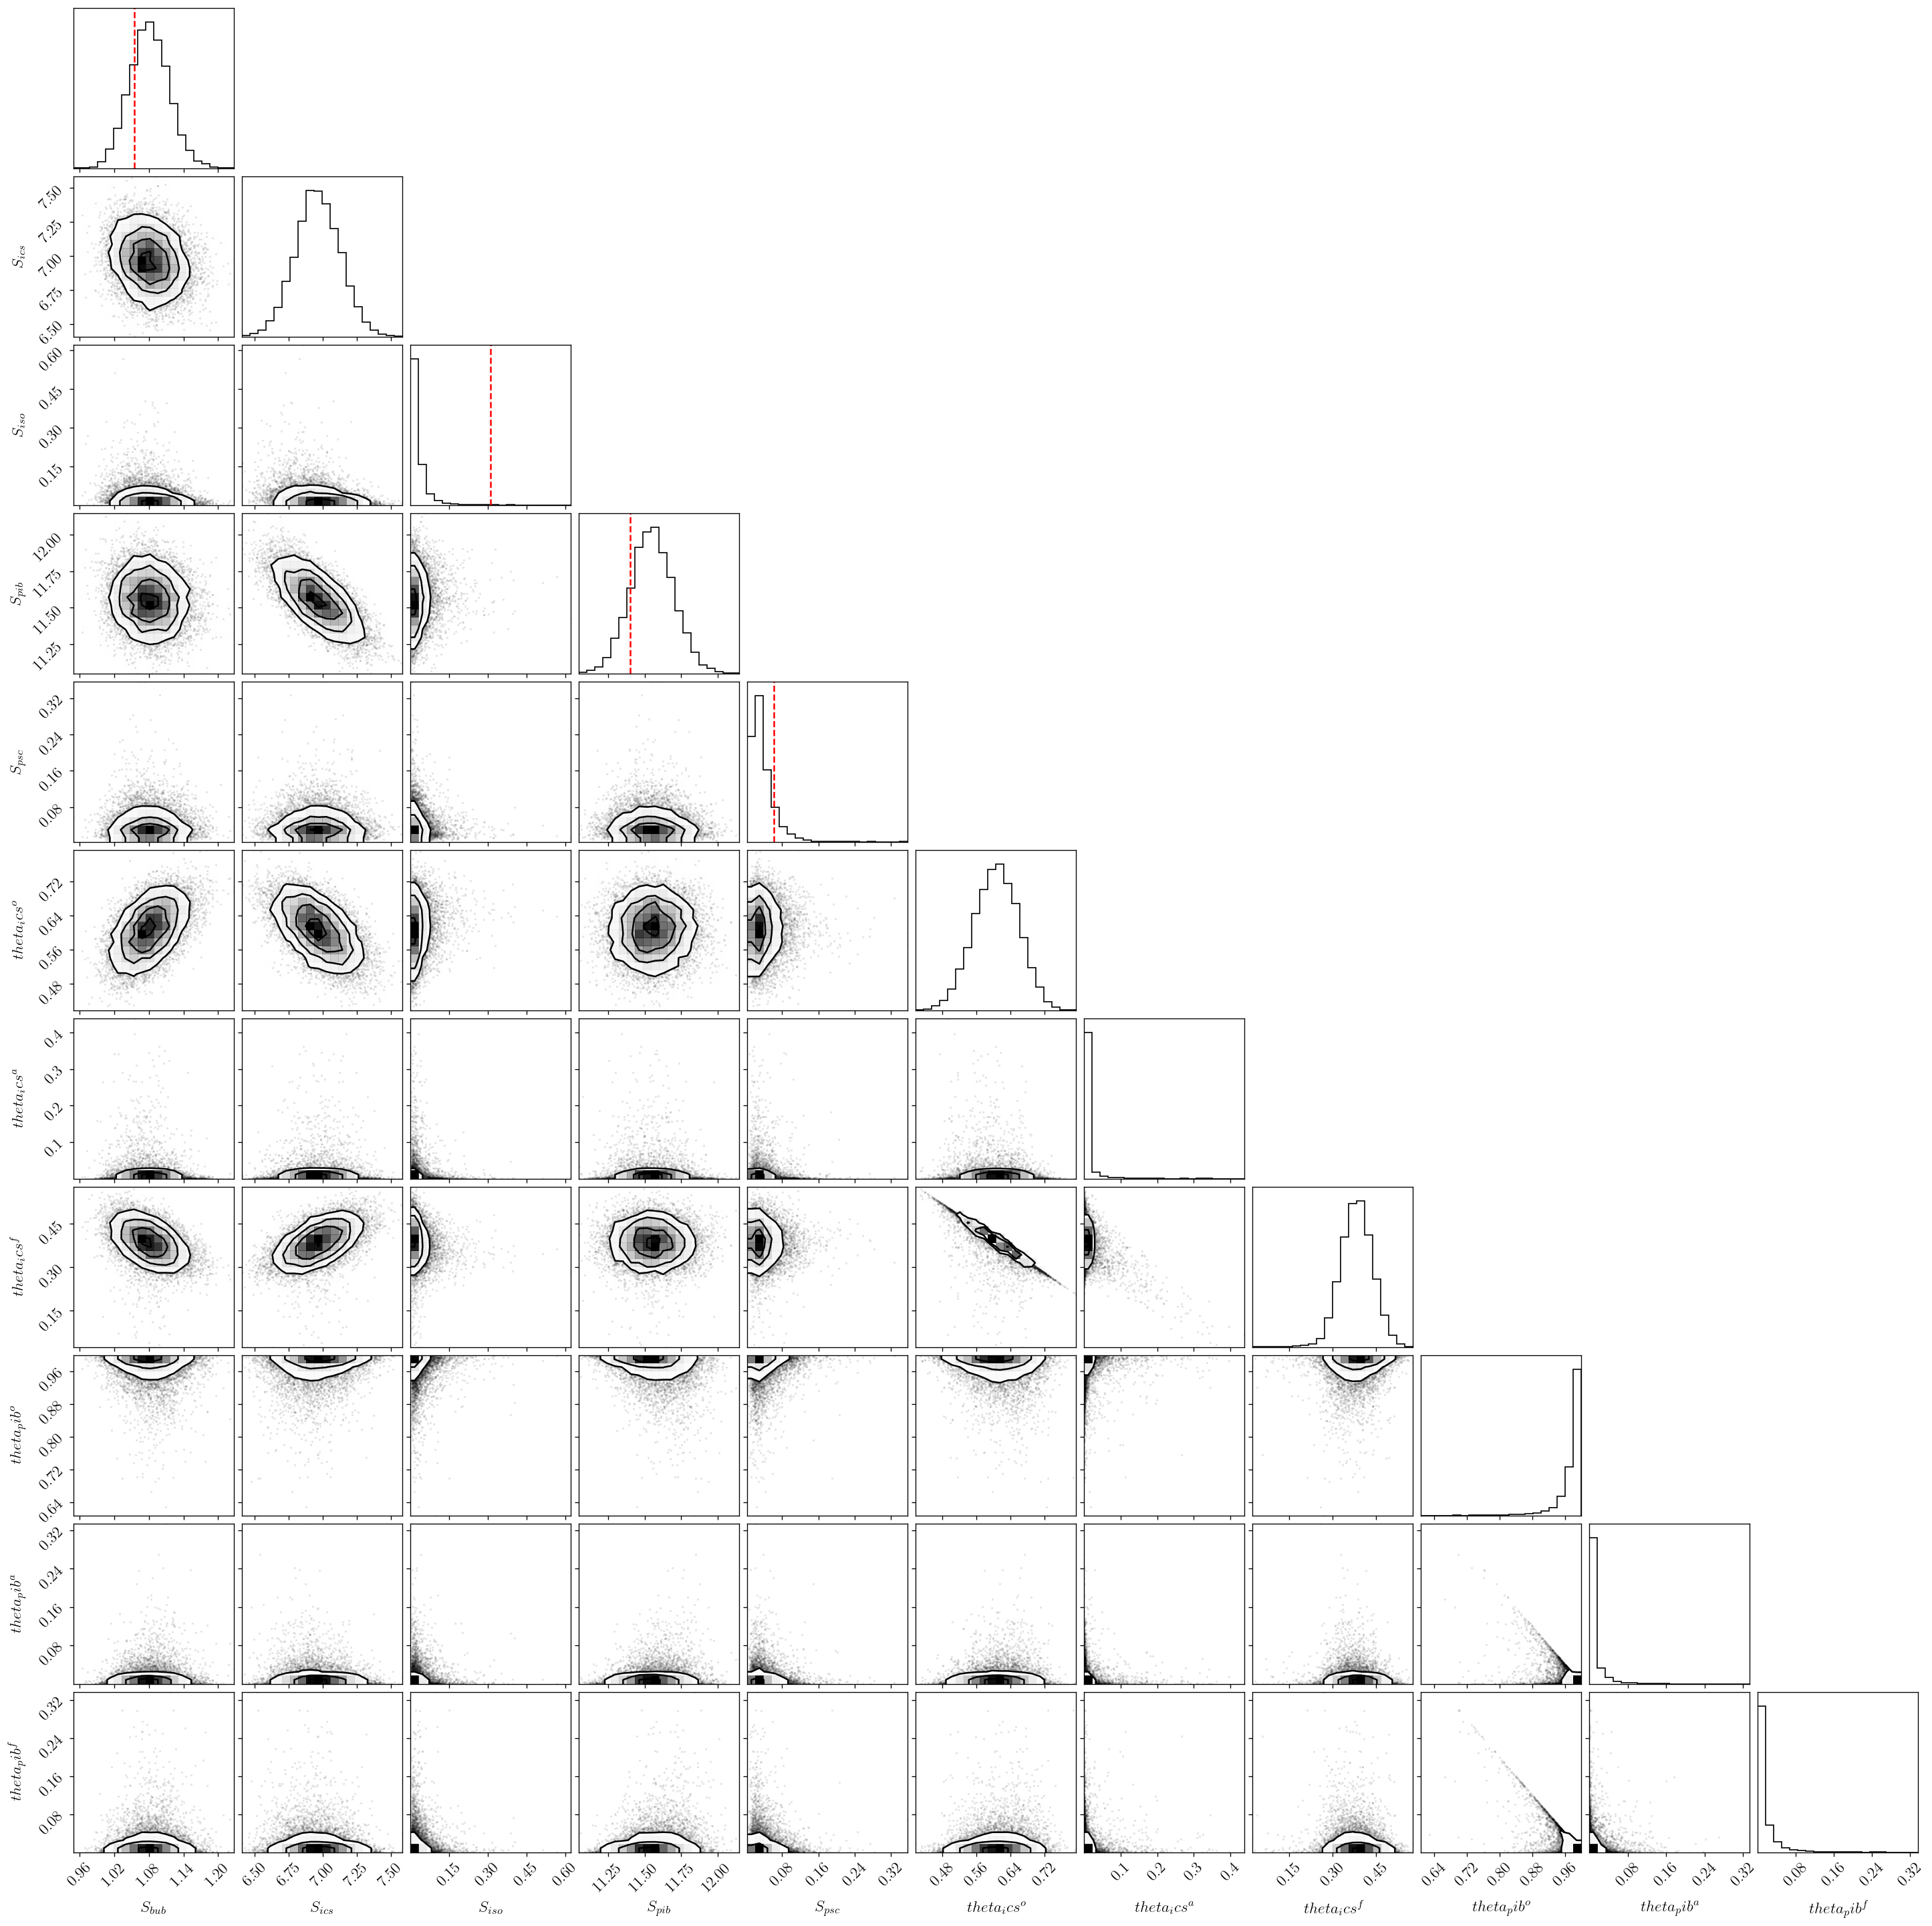

: 

In [41]:
import corner

p_tr = [true_params[k] for k in keys if k not in ['theta_ics', 'theta_pib']]
Np = len(p_tr) 
Ntot = temp_samples_tot_list.T.shape[1]

def gen_labels(keys):
    def format_S(k):
        if 'S' in k:
            return '$S_{'+k.split('_')[1]+'}$'
        return '$'+k+'$'
    def format_theta(k):
        return '$\\theta_{'+k.split('_')[1]+'}^{'+k.split('_')[2]+'}$'
    
    labels = []
    for k in keys:
        if 'theta' in k:
            for i in range(len(ebinmodel.dif_names)):
                labels.append('$'+k+'^{'+ebinmodel.dif_names[i][-1]+'}$')
        else:
            labels.append(format_S(k))
    return labels
print(keys)
labels = gen_labels(keys)
print(labels)
# labels =['$S_{blg}$', '$S_{bub}$', '$S_{ics}$', '$S_{iso}$', '$S_{nfw}$', '$S_{pib}$', '$S_{psc}$', 
#          '$\\theta_{ics}^{o}$', '$\\theta_{ics}^{a}$', '$\\theta_{pib}^{o}$','$\\theta_{pib}^{a}$']
# labels = ['$S_{bub}$', '$S_{ics}$', '$S_{pib}$', '$S_{psc}$', '$S_{blg}$', '$S_{iso}$', '$S_{nfw}$','$\\gamma$']

fig = corner.corner(temp_samples_tot_list.T, labels = labels, )
axes = np.array(fig.axes).reshape((Ntot, Ntot))
for i in range(Np):
    ax = axes[i,i]
    ax.axvline(p_tr[i], color='red', linestyle='--')

In [8]:
# generate samples and plot histograms of log counts

temp_names_sim = rig_temp_sim + hyb_temp_sim + var_temp_sim # imported from settings file
temp_sample_dict = ef.generate_temp_sample_maps(samples, ebinmodel, gp_samples = gp_samples)

psc
bub
pib


100%|██████████| 1000/1000 [00:01<00:00, 727.71it/s]


ics


100%|██████████| 1000/1000 [00:01<00:00, 878.23it/s]


/data/edr76/gce-prob-prog-ed-v0.3/gp_settings/../utils/ed_fcts.py:662: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))


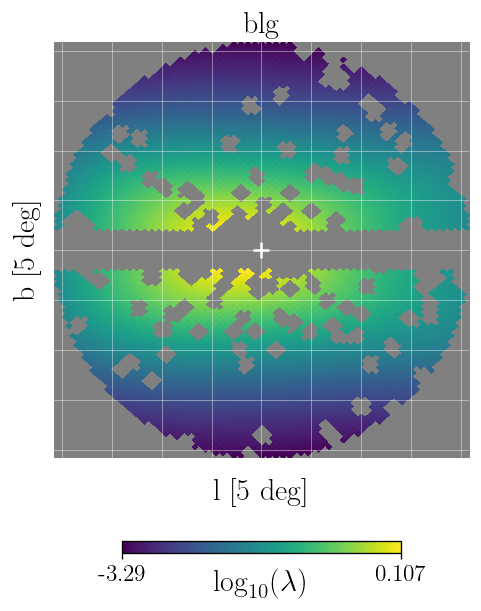

In [9]:
temp_blg = temp_dict['blg']
mask_p = ebinmodel.mask_roi_arr[ebin]

fig = plt.figure(figsize=(6, 6), dpi= 120)
ax = fig.add_subplot(111)
plt.axes(ax)
temp_blg_hp = ef.convert_masked_array_to_hp_array(temp_blg, mask_p, log_option = True, nside=nside)
ef.gnomview_plot(temp_blg_hp, title = 'blg')

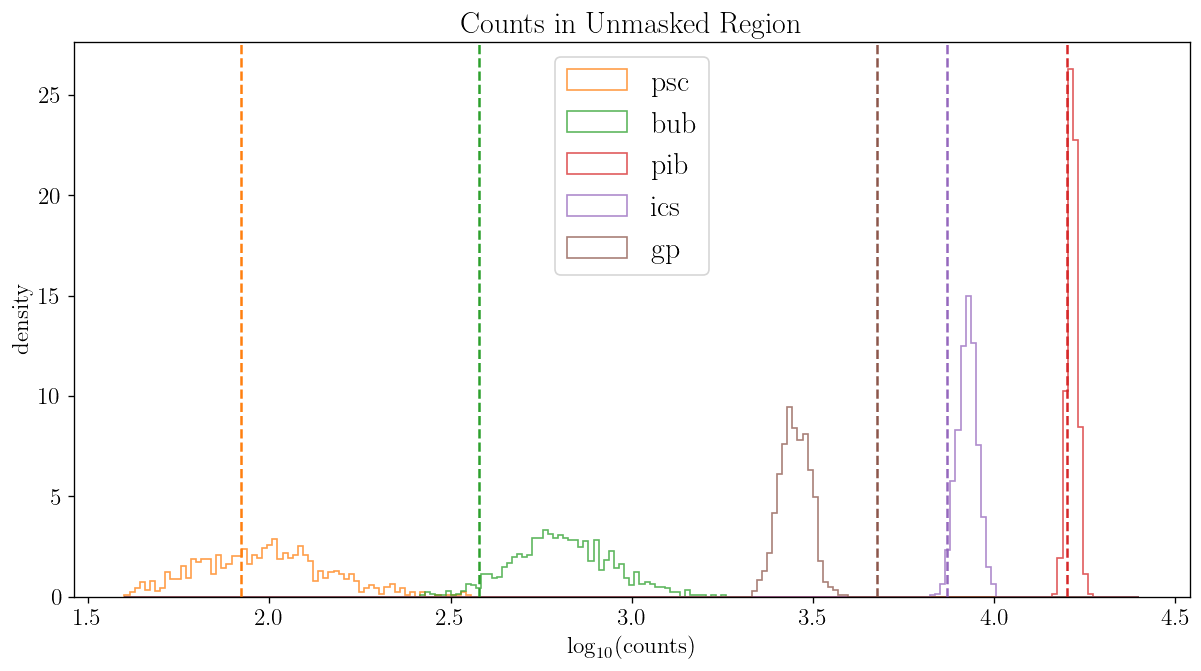

In [10]:
ef.tot_log_counts_hist(temp_sample_dict, temp_dict, temp_names_sim, bins = np.linspace(1.6,4.4,200), gp_model_nfw=True, gp_model_iso = True)

In [11]:
print(np.std(temp_sample_dict['gp'].sum(axis = 1)))

272.13486


In [12]:
print(gp_samples.shape)

(1000, 4234)


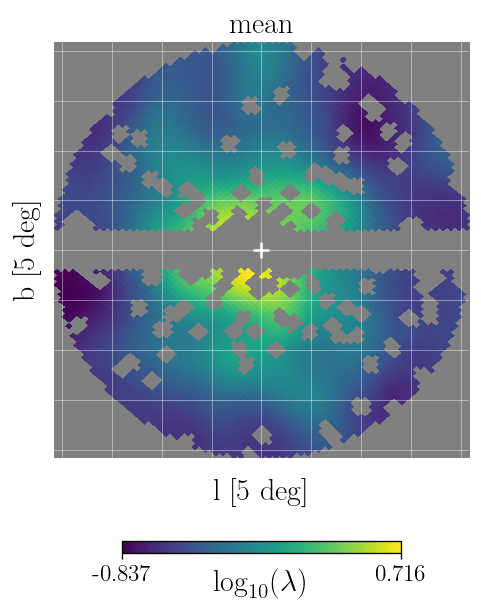

In [13]:
q = np.percentile(gp_samples, [16,50,84], axis = 0)

fig = plt.figure(figsize=(6, 6), dpi= 120)

map_p = ef.convert_masked_array_to_hp_array(np.exp(q[1]), mask, log_option = True, nside = 128)

ax = fig.add_subplot(1,1,1)
plt.axes(ax)
ef.gnomview_plot(map_p,'mean')

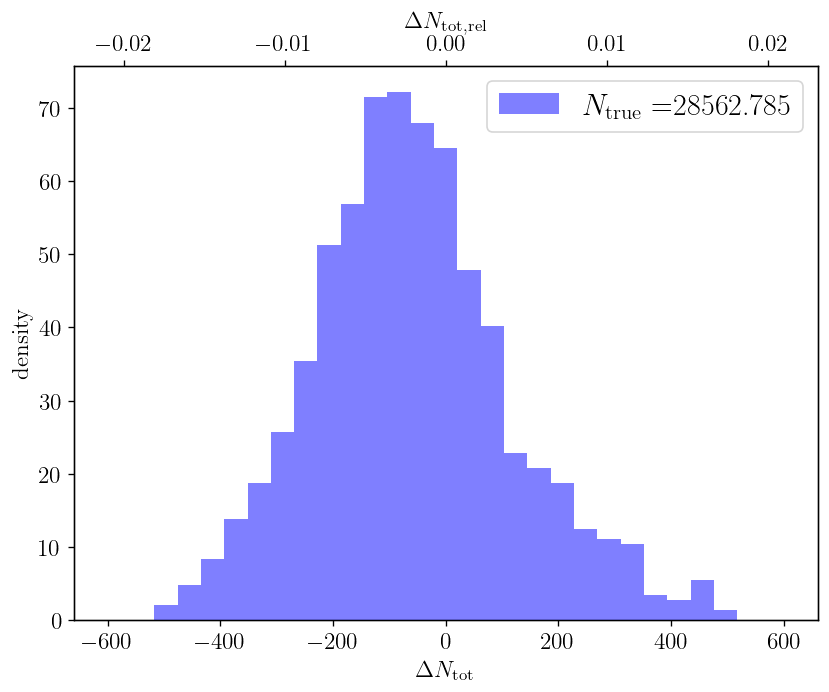

In [14]:
from utils import ed_fcts as ef
ef.tot_counts_hist_all_temps(temp_sample_dict, temp_dict, temp_names_sim, bins = np.linspace(-600,600,30))

In [15]:
from utils import ed_fcts as ef

# take quantiles of samples
Nx1, Nx2, x1_plt, x2_plt, x1_c, x2_c, x = ef.cart_coords()

exp_gp_samples = np.exp(gp_samples)
exp_gp_samples_cart = ef.multi_healpix_to_cart(exp_gp_samples, mask, n_pixels=80, nside = 128)
q = np.percentile(exp_gp_samples_cart, [16,50,84], axis = 0)

sim_cart = ef.healpix_to_cart(temp_dict['blg'] + temp_dict['nfw'] + temp_dict['iso'], mask, n_pixels=80, nside = 128)
raw_cart = ef.healpix_to_cart(ebinmodel.counts[ebin][~mask], mask, n_pixels=80, nside = 128)

100%|██████████| 1000/1000 [00:07<00:00, 133.36it/s]


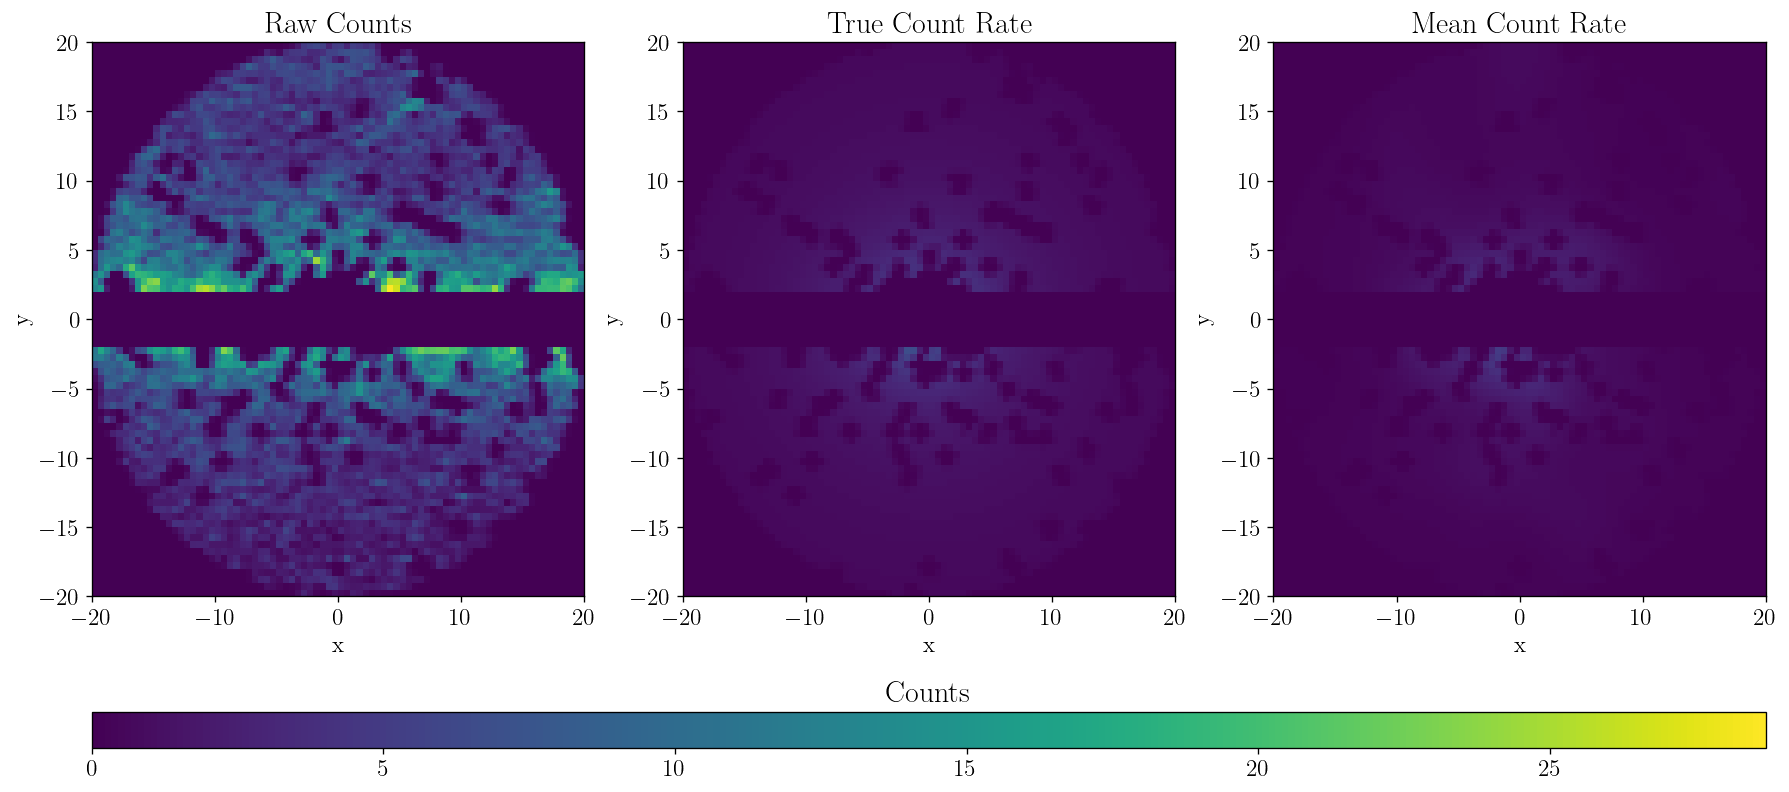

In [16]:
from utils import ed_fcts as ef

# plot raw count map, true rate map, and mean rate map from posterior of log_rate

ef.triple_cart_plot(x1_plt, x2_plt, raw_cart, sim_cart, q[1])

Text(0, 0.5, 'y')

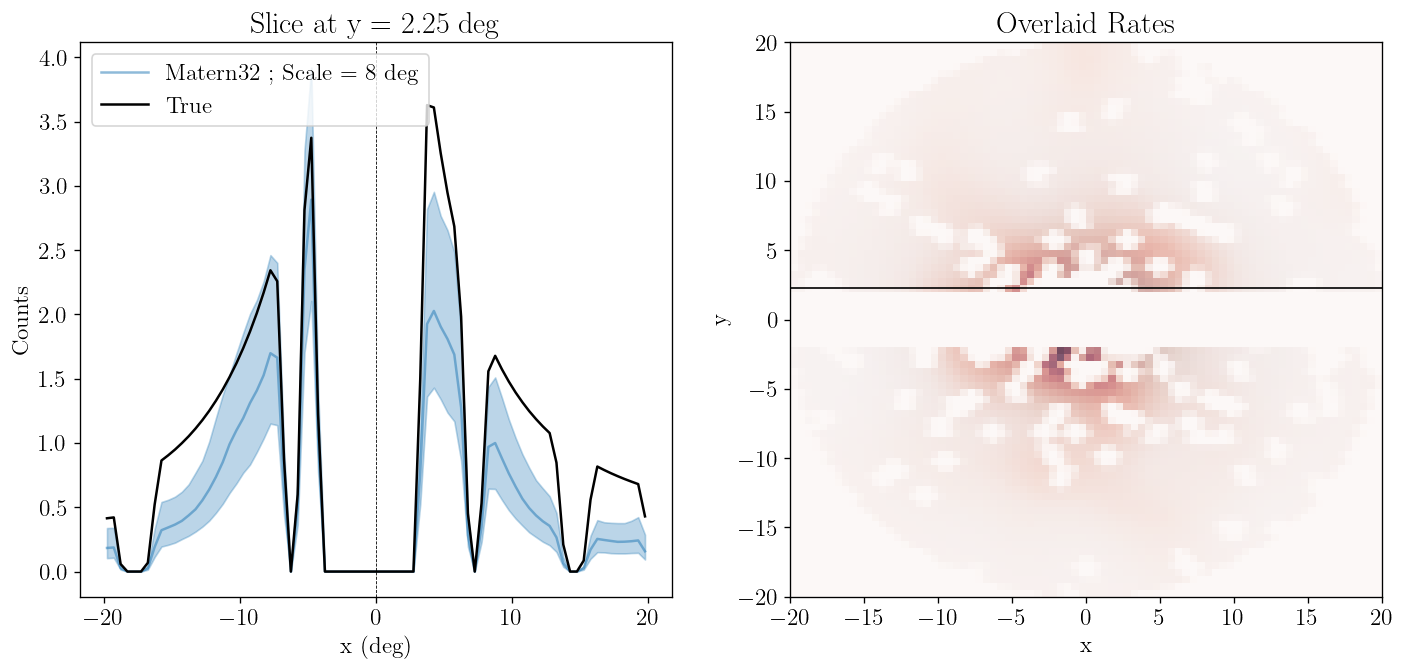

: 

In [17]:
fig = plt.figure(figsize=(14, 6), dpi= 120)

blg_coord = sim_cart
sim_coord = None
res_scale = 1
yscale = 'linear'

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

y_slice = 2.
ny = np.where(np.abs(x2_c - y_slice) < 0.5 * res_scale)[0][1]

ccode = 'C0'
ax1.plot(x[ny,:,0], q[1][ny,:], c = ccode, label = str('Matern32 ; Scale = 8 deg'), alpha = 0.5)
ax1.fill_between(x[ny,:,0], q[0][ny,:], q[2][ny,:], color = ccode, alpha = 0.3)

ax1.plot(x[ny,:,0], blg_coord[ny,:], c = 'k', label = 'True')
if sim_coord is not None:
    ax1.errorbar(x[ny,:,0], sim_coord[ny,:], yerr = np.sqrt(sim_coord[ny,:]), fmt = 'o', c = 'k', alpha = 0.5)
ax1.set_xlabel('x (deg)')
ax1.set_ylabel('Counts')
ax1.set_title('Slice at y = {:.2f} deg'.format(x[ny,0,1]))
ax1.legend(fontsize = 14)
ax1.axvline(0, color='k', ls = '--', lw = 0.5)
ax1.set_yscale(yscale)

ax2.pcolormesh(x1_plt, x2_plt, blg_coord, cmap='Blues', alpha = 0.5)
ax2.pcolormesh(x1_plt, x2_plt, q[1], cmap='Reds', alpha = 0.5)
if sim_coord is not None:
    ax2.pcolormesh(x1_plt, x2_plt, sim_coord, cmap='Greys', alpha = 0.2)
ax2.axhline(y = x[ny,0,1], c = 'k', lw = 1)
ax2.set_title('Overlaid Rates')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

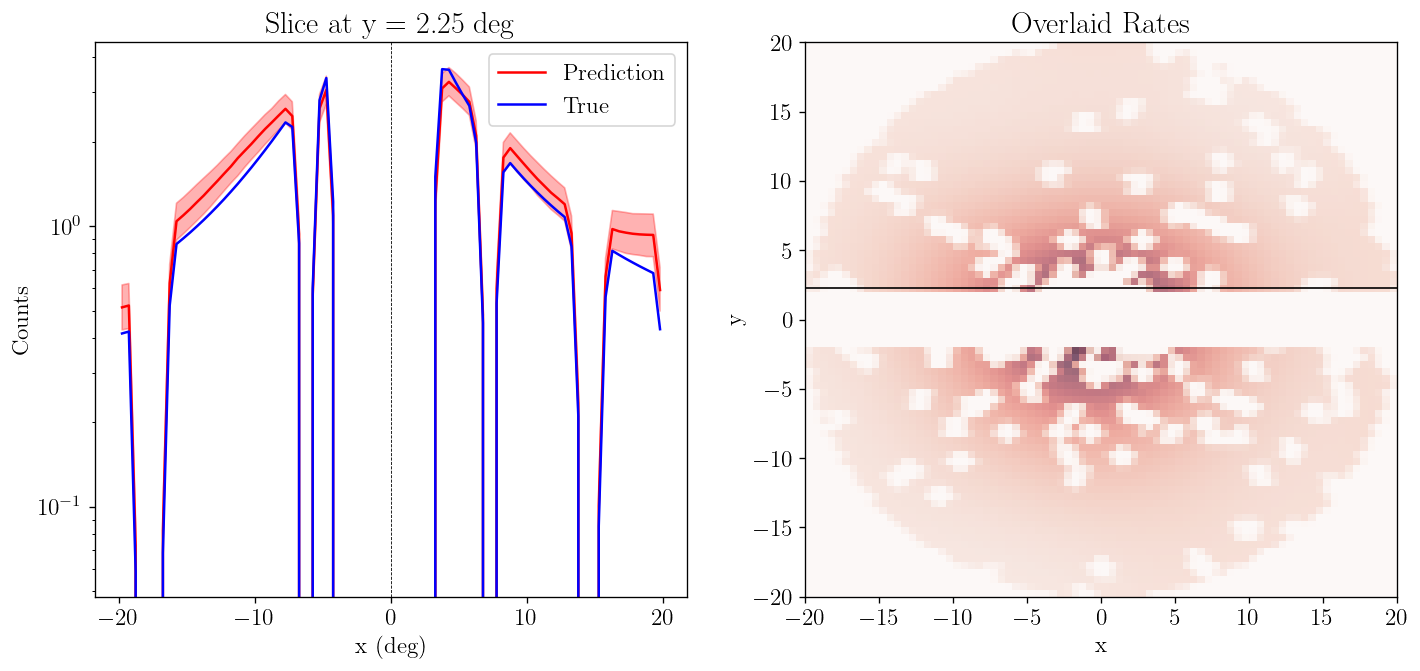

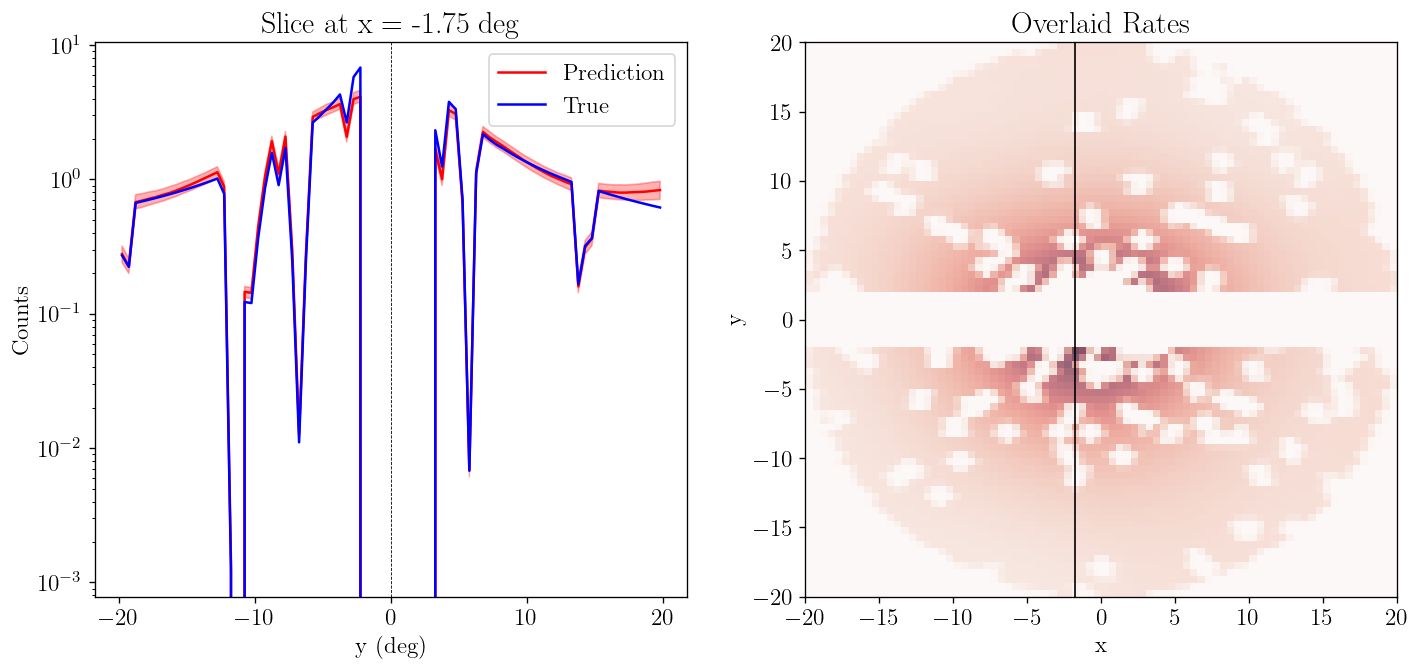

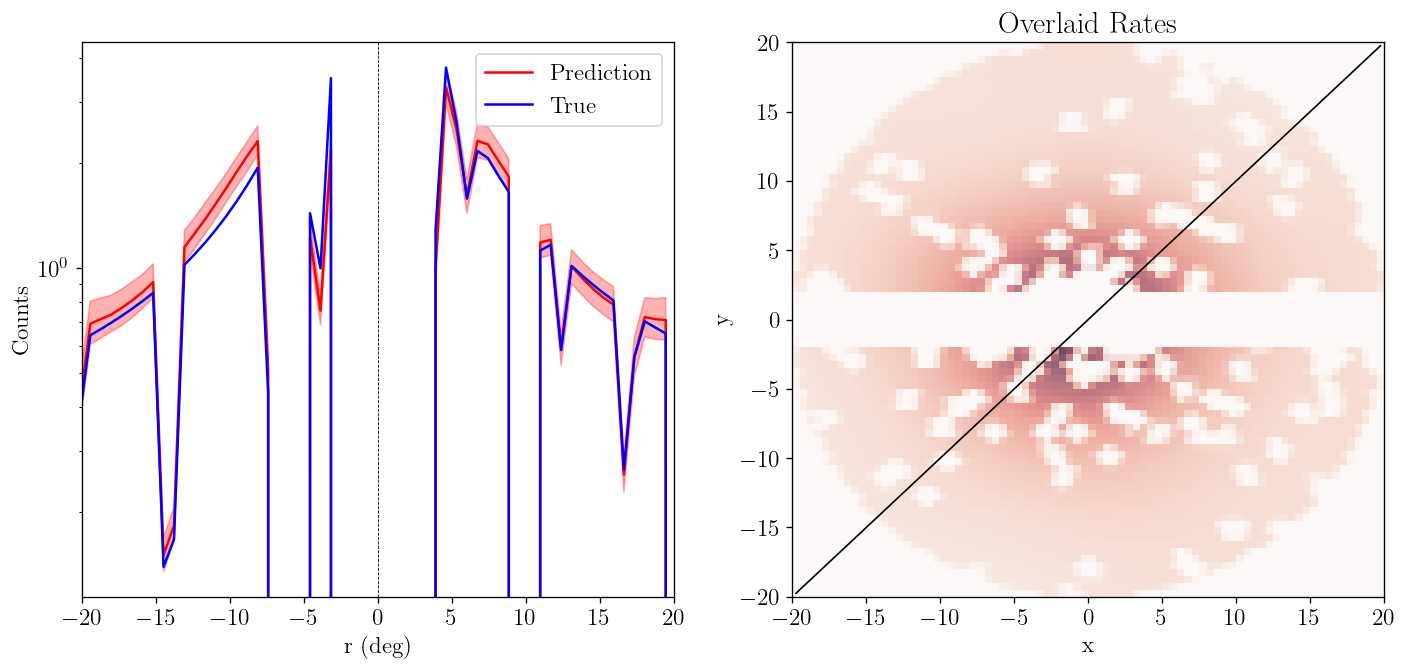

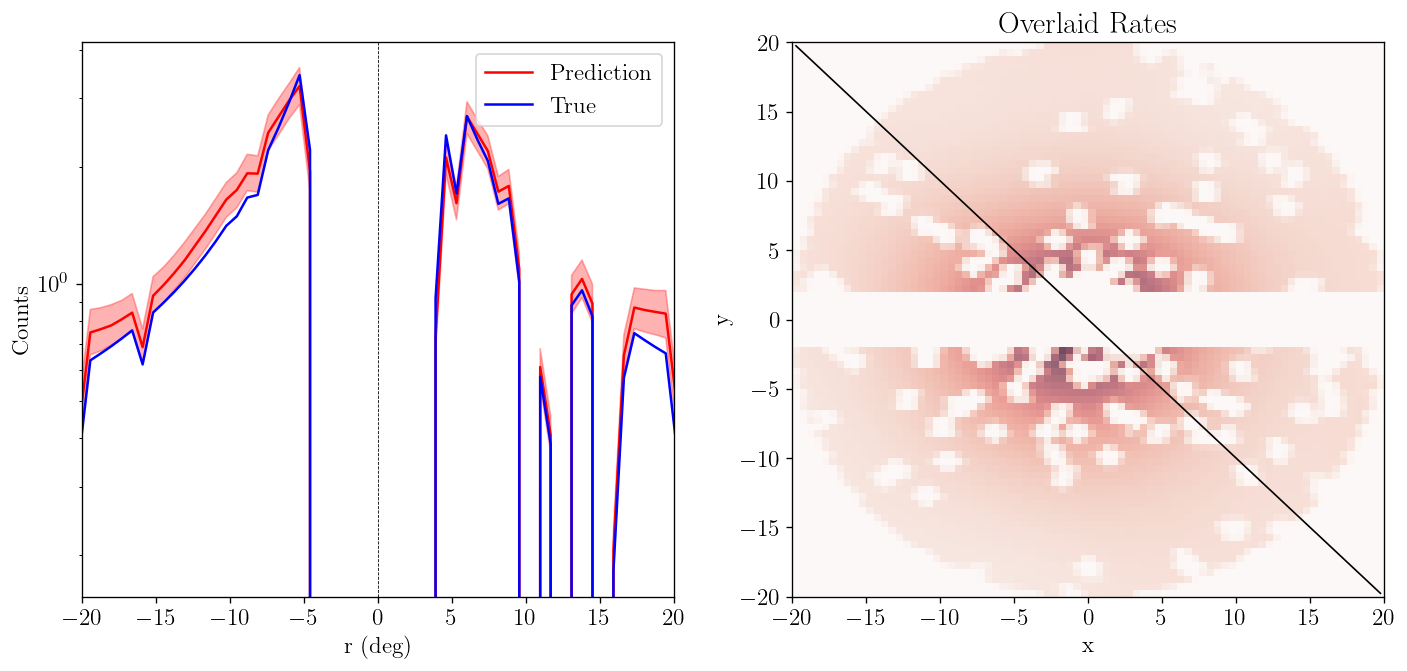

In [41]:
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q, blg_coord=sim_cart, sim_coord=None, slice_dir = 'horizontal', slice_val = 2., res_scale = 1)
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q, blg_coord=sim_cart, sim_coord=None, slice_dir = 'vertical', slice_val = 2., res_scale = 1)
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q, blg_coord=sim_cart, sim_coord=None, slice_dir = 'diagonal_up', slice_val = 2., res_scale = 1)
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q, blg_coord=sim_cart, sim_coord=None, slice_dir = 'diagonal_down', slice_val = 2., res_scale = 1)

In [104]:
from utils import ed_fcts as ef

# take quantiles of samples
Nx1, Nx2, x1_plt, x2_plt, x1_c, x2_c, x = ef.cart_coords()

S_ics = samples['S_ics'][:1000][:,None]
ics_temp = ebinmodel.ics_temps[0].at_bin(ebin, mask=mask)[None,:]

ics_samples = S_ics * ics_temp
ics_samples_cart = ef.multi_healpix_to_cart(ics_samples, mask, n_pixels=80, nside = 128)
q = np.percentile(ics_samples_cart, [16,50,84], axis = 0)

sim_cart = ef.healpix_to_cart(temp_dict['ics'], mask, n_pixels=80, nside = 128)

100%|██████████| 1000/1000 [00:09<00:00, 108.19it/s]


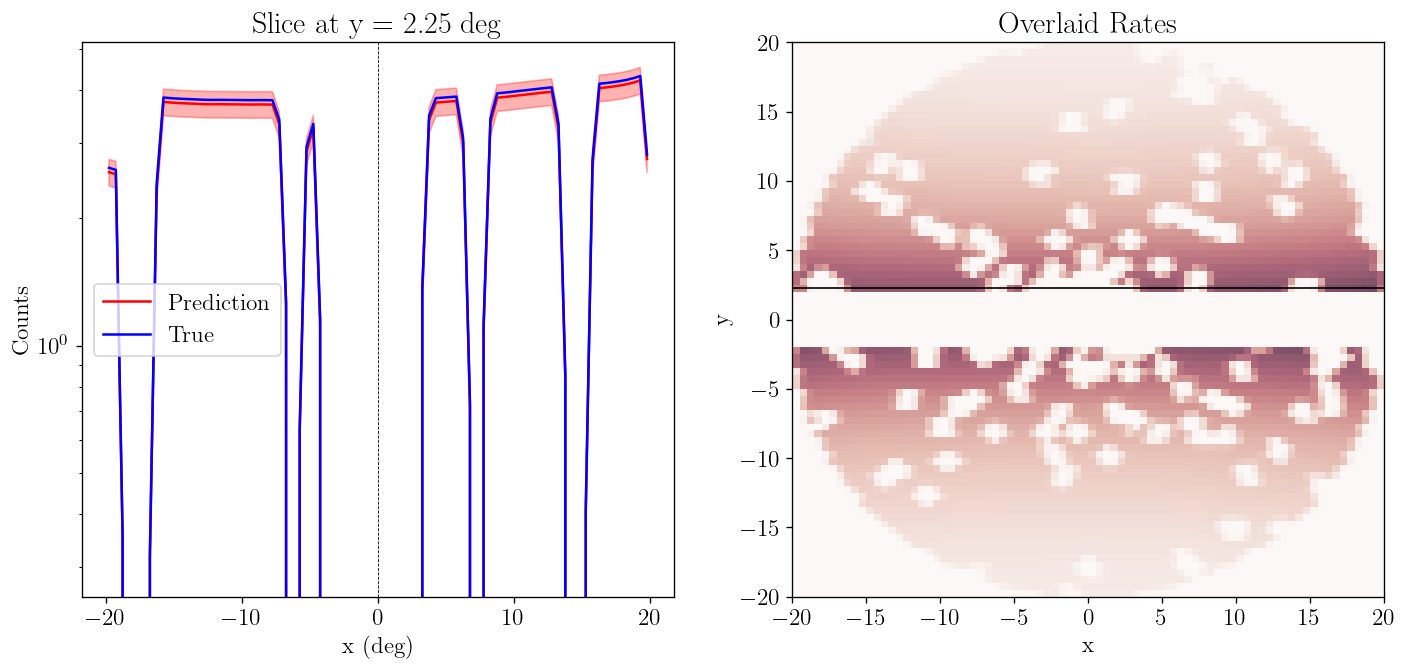

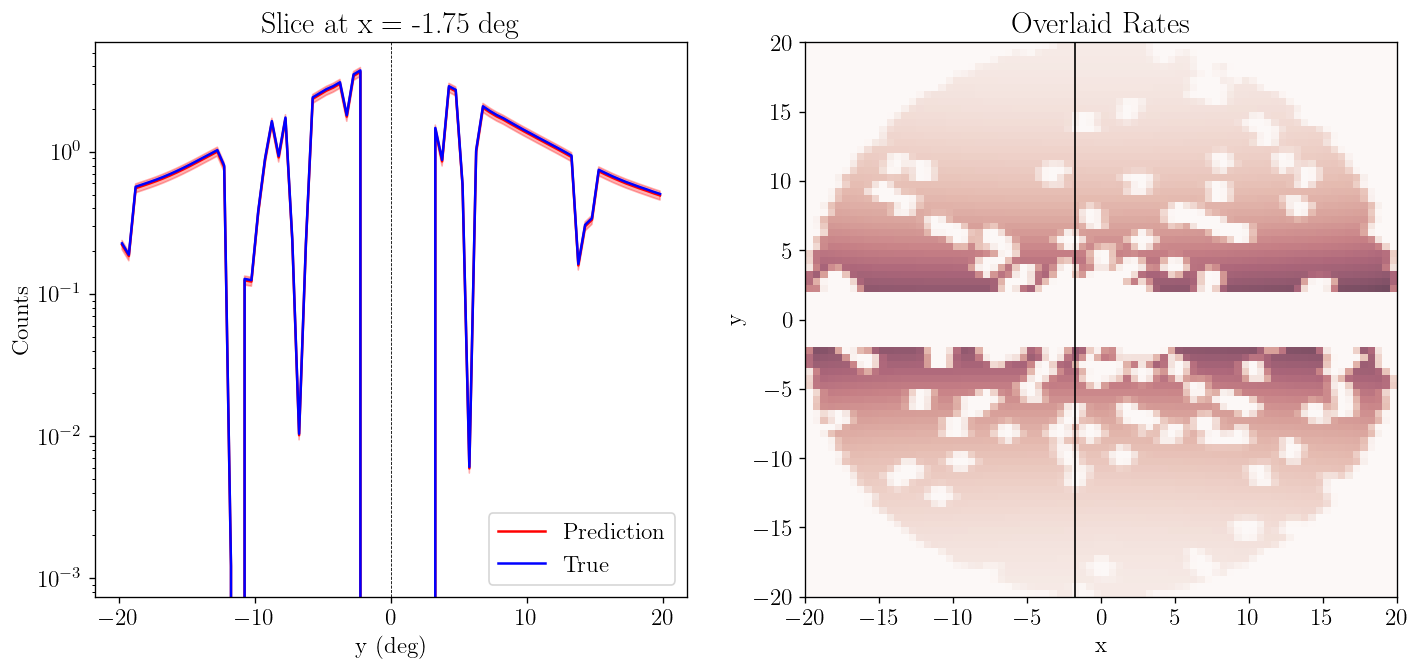

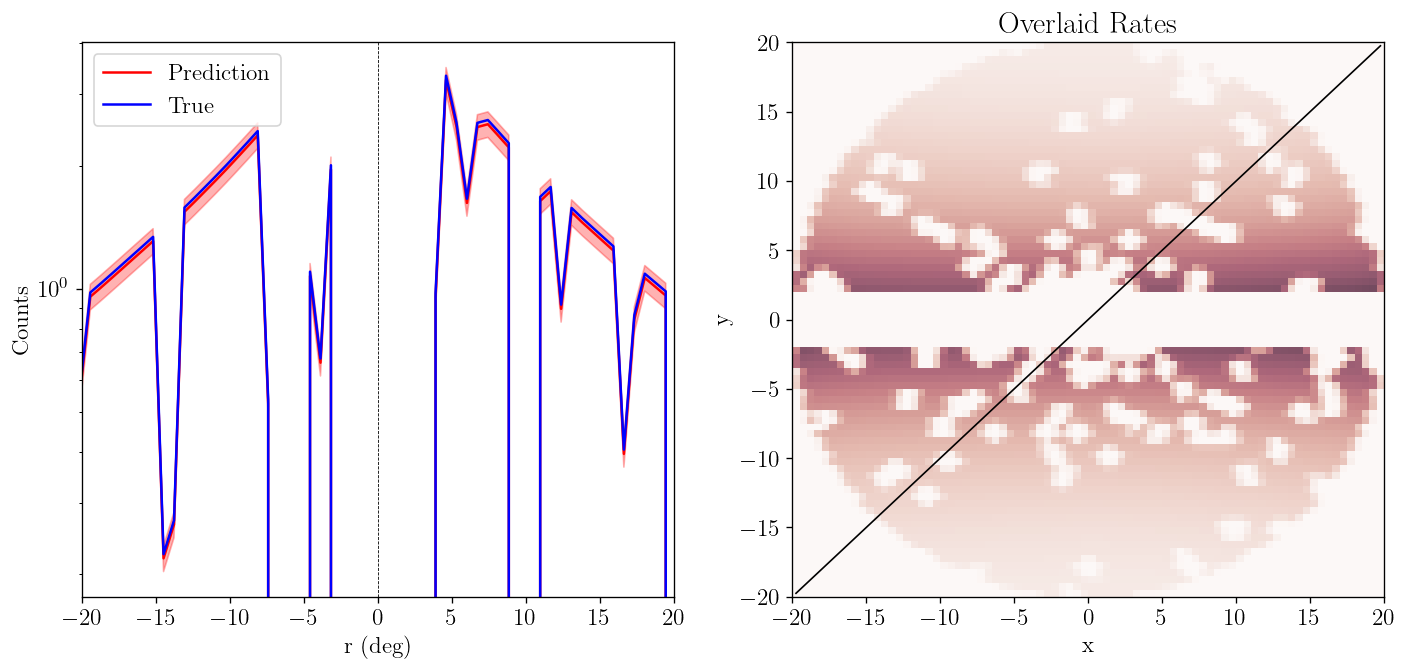

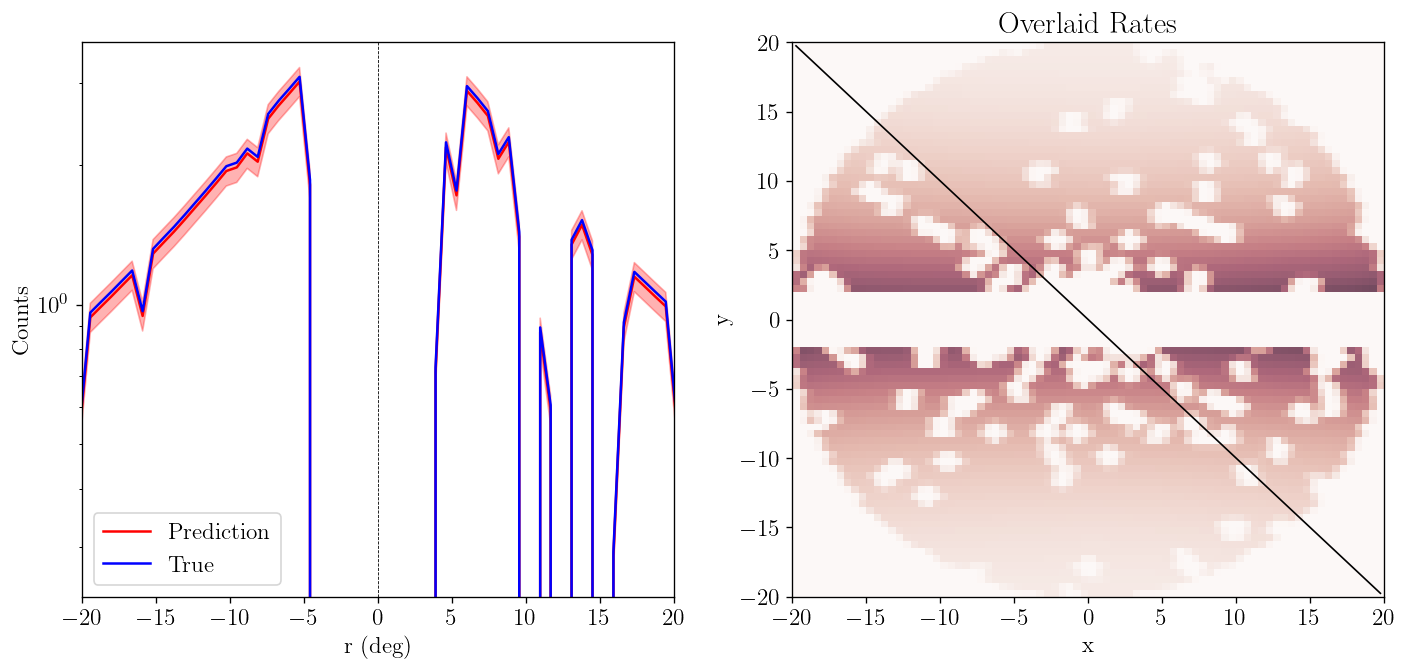

In [105]:
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q, blg_coord=sim_cart, sim_coord=None, slice_dir = 'horizontal', slice_val = 2., res_scale = 1)
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q, blg_coord=sim_cart, sim_coord=None, slice_dir = 'vertical', slice_val = 2., res_scale = 1)
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q, blg_coord=sim_cart, sim_coord=None, slice_dir = 'diagonal_up', slice_val = 2., res_scale = 1)
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q, blg_coord=sim_cart, sim_coord=None, slice_dir = 'diagonal_down', slice_val = 2., res_scale = 1)

In [106]:
from utils import ed_fcts as ef

# take quantiles of samples
Nx1, Nx2, x1_plt, x2_plt, x1_c, x2_c, x = ef.cart_coords()

jnt_samples = ics_samples + exp_gp_samples
jnt_samples_cart = ef.multi_healpix_to_cart(jnt_samples, mask, n_pixels=80, nside = 128)
q = np.percentile(jnt_samples_cart, [16,50,84], axis = 0)

sim_cart = ef.healpix_to_cart(temp_dict['ics'] + temp_dict['blg'] + temp_dict['nfw'] + temp_dict['iso'], mask, n_pixels=80, nside = 128)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:09<00:00, 105.85it/s]


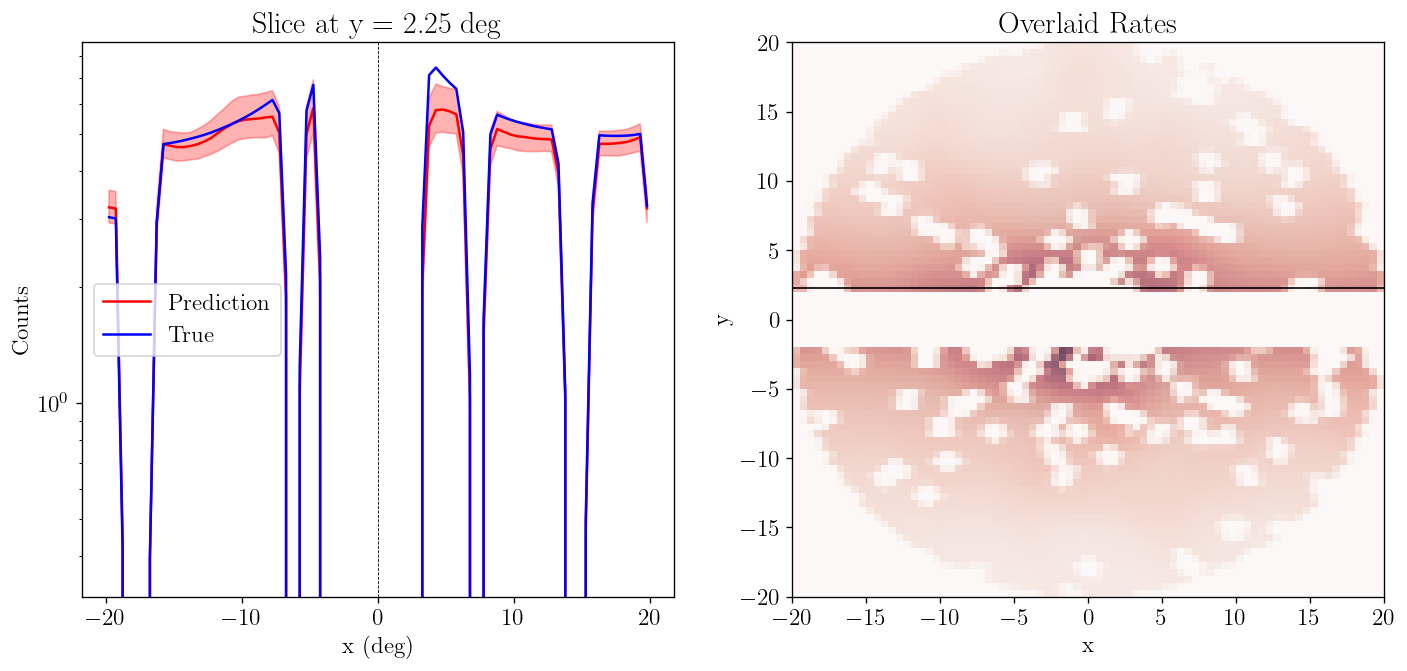

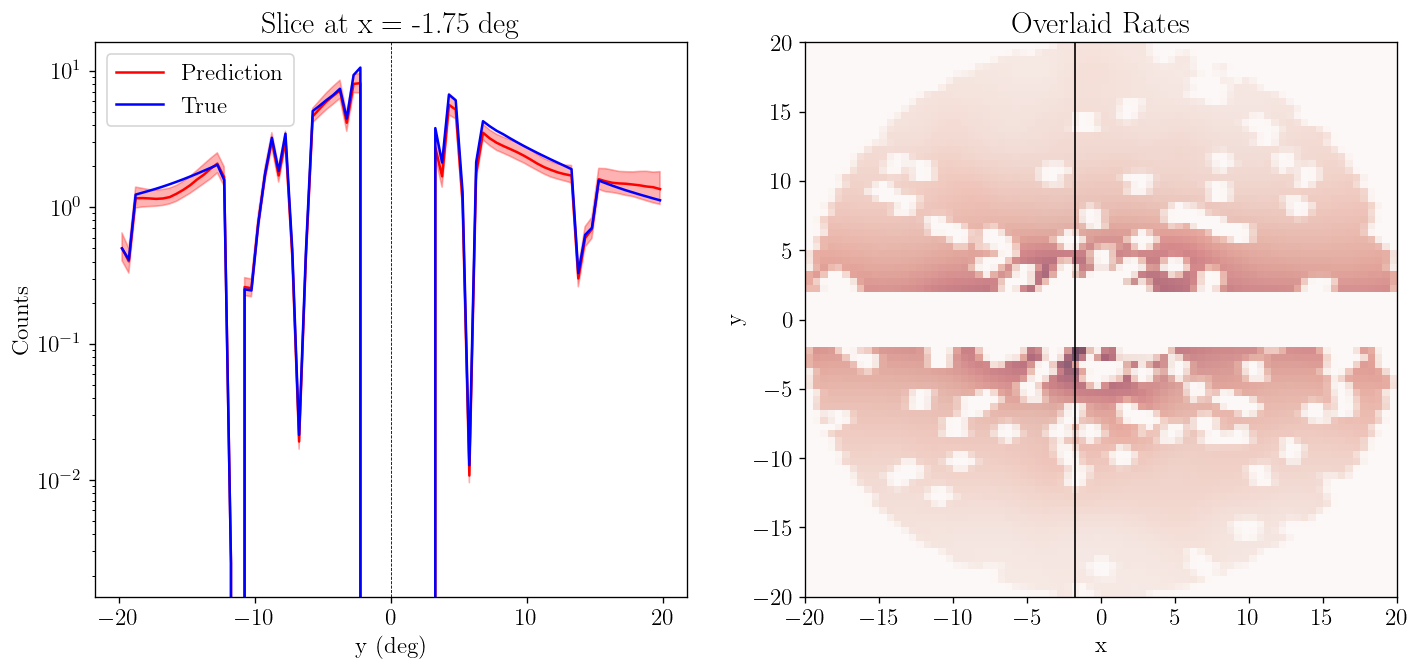

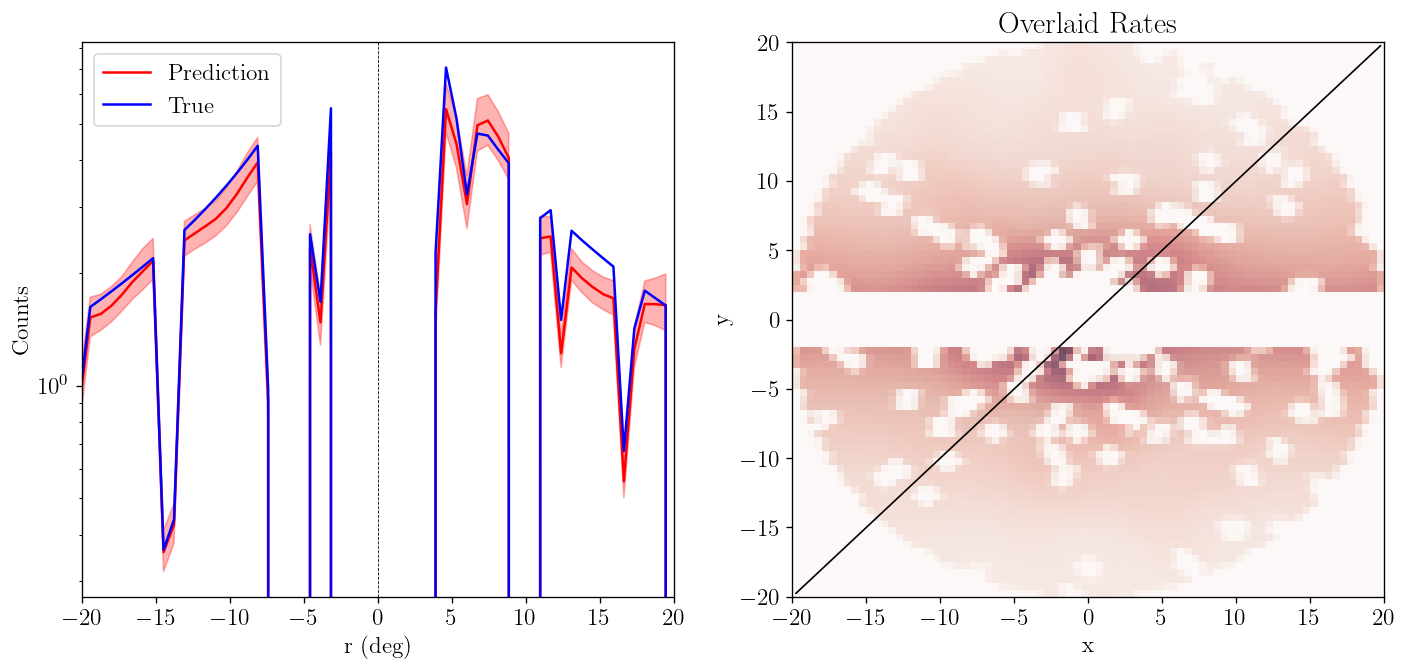

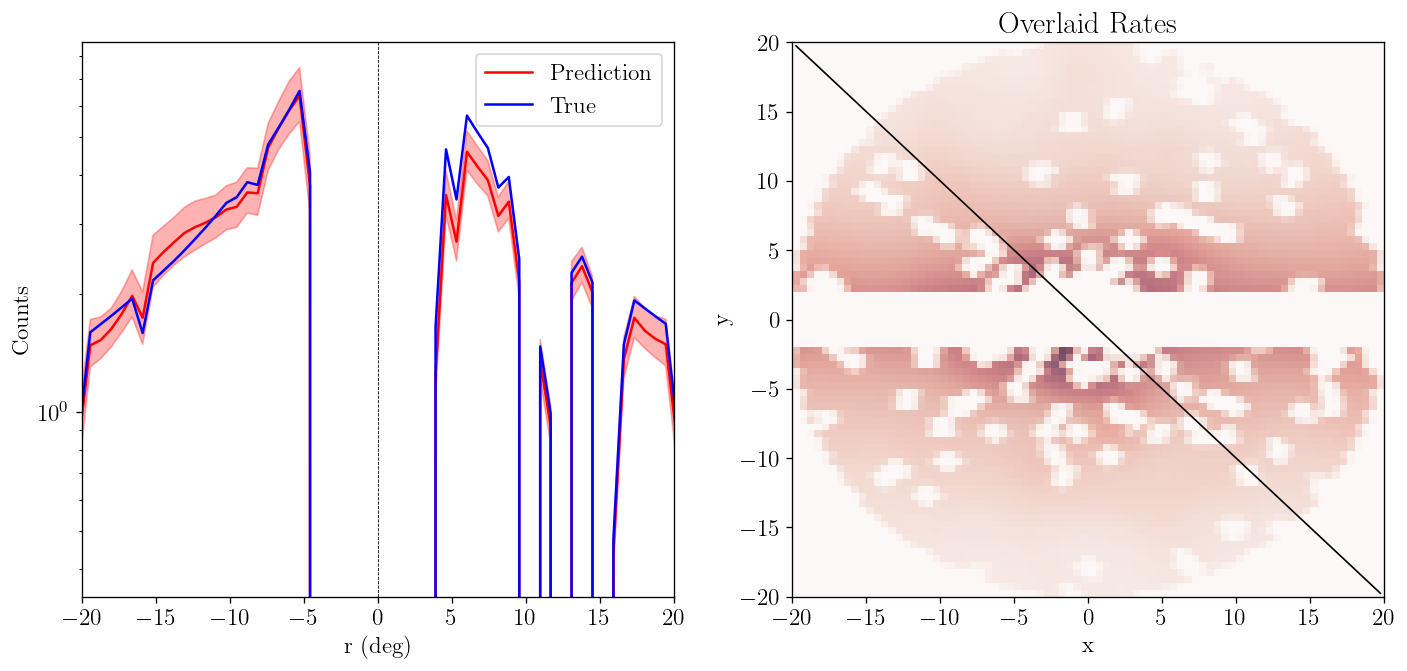

In [107]:
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q, blg_coord=sim_cart, sim_coord=None, slice_dir = 'horizontal', slice_val = 2., res_scale = 1)
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q, blg_coord=sim_cart, sim_coord=None, slice_dir = 'vertical', slice_val = 2., res_scale = 1)
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q, blg_coord=sim_cart, sim_coord=None, slice_dir = 'diagonal_up', slice_val = 2., res_scale = 1)
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q, blg_coord=sim_cart, sim_coord=None, slice_dir = 'diagonal_down', slice_val = 2., res_scale = 1)

In [108]:
tot_samples = jnp.zeros(temp_sample_dict['gp'].shape)
tot_names = list(temp_sample_dict.keys())
for tot_name in tot_names:
    tot_samples += temp_sample_dict[tot_name]

tot_samples_cart = ef.multi_healpix_to_cart(tot_samples, mask, n_pixels=80, nside = 128)
q_tot = np.percentile(tot_samples_cart, [16,50,84], axis = 0)

sim_samples = jnp.zeros(temp_dict['blg'].shape)
for sim_name in temp_names_sim:
    sim_samples += temp_dict[sim_name]
sim_cart = ef.healpix_to_cart(sim_samples, mask, n_pixels=80, nside = 128)

raw_cart = ef.healpix_to_cart(ebinmodel.counts[ebin][~mask], mask, n_pixels=80, nside = 128)

100%|██████████| 1000/1000 [00:08<00:00, 111.21it/s]


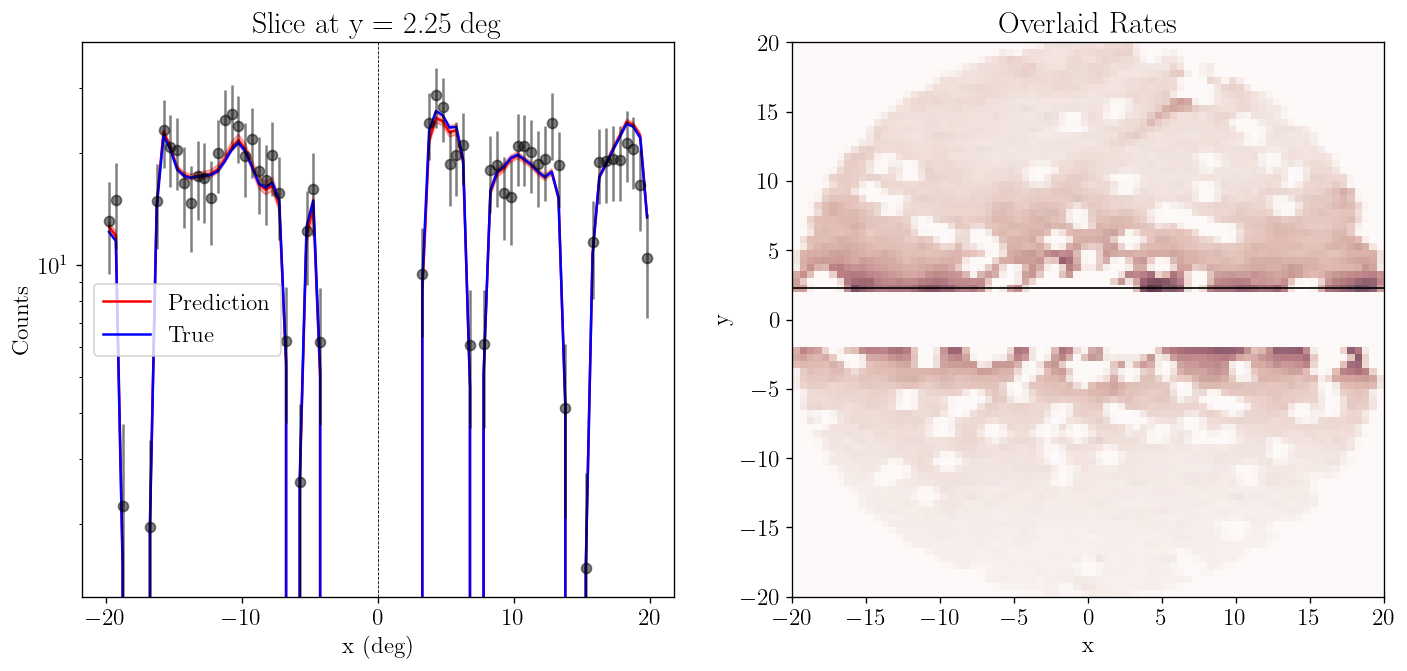

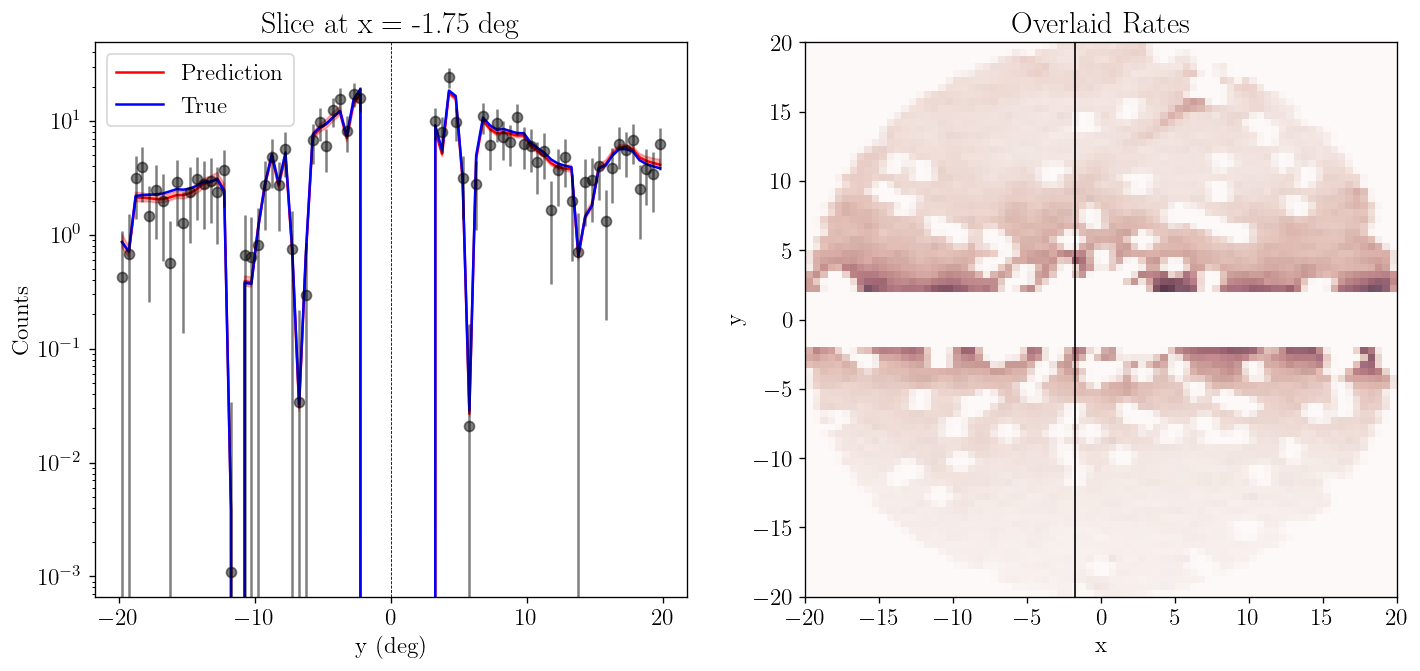

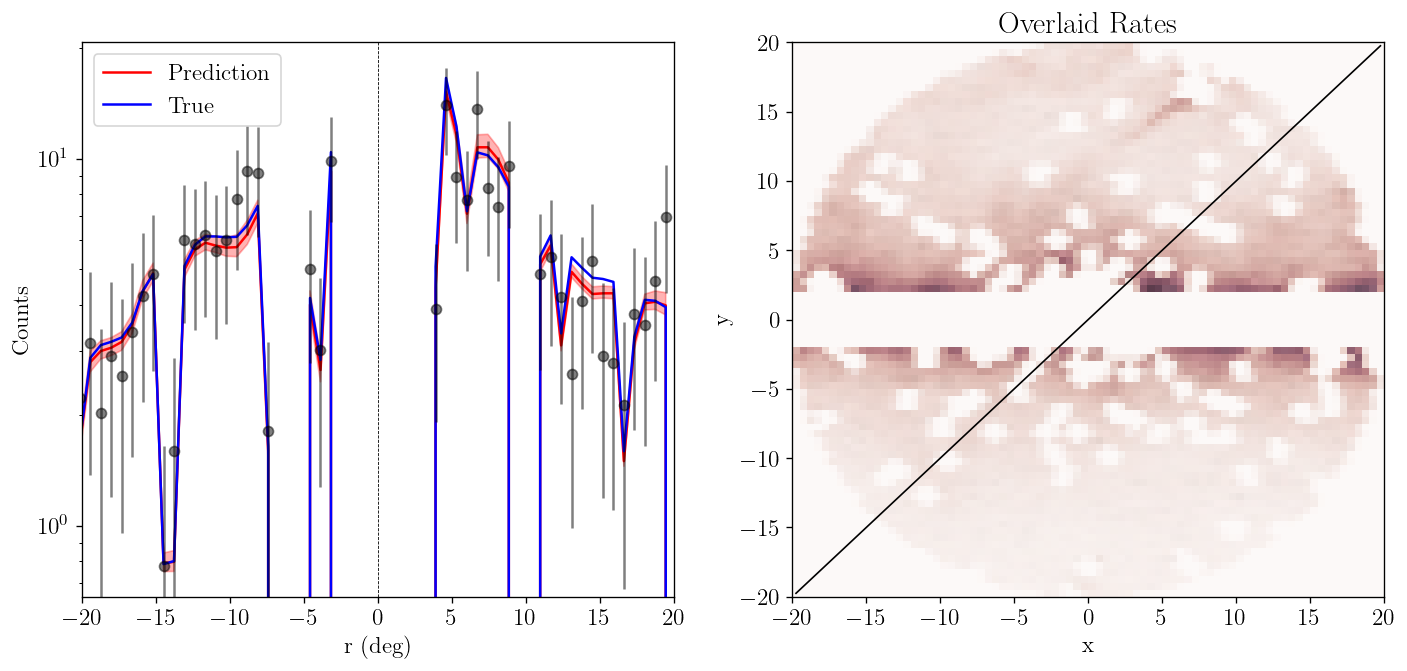

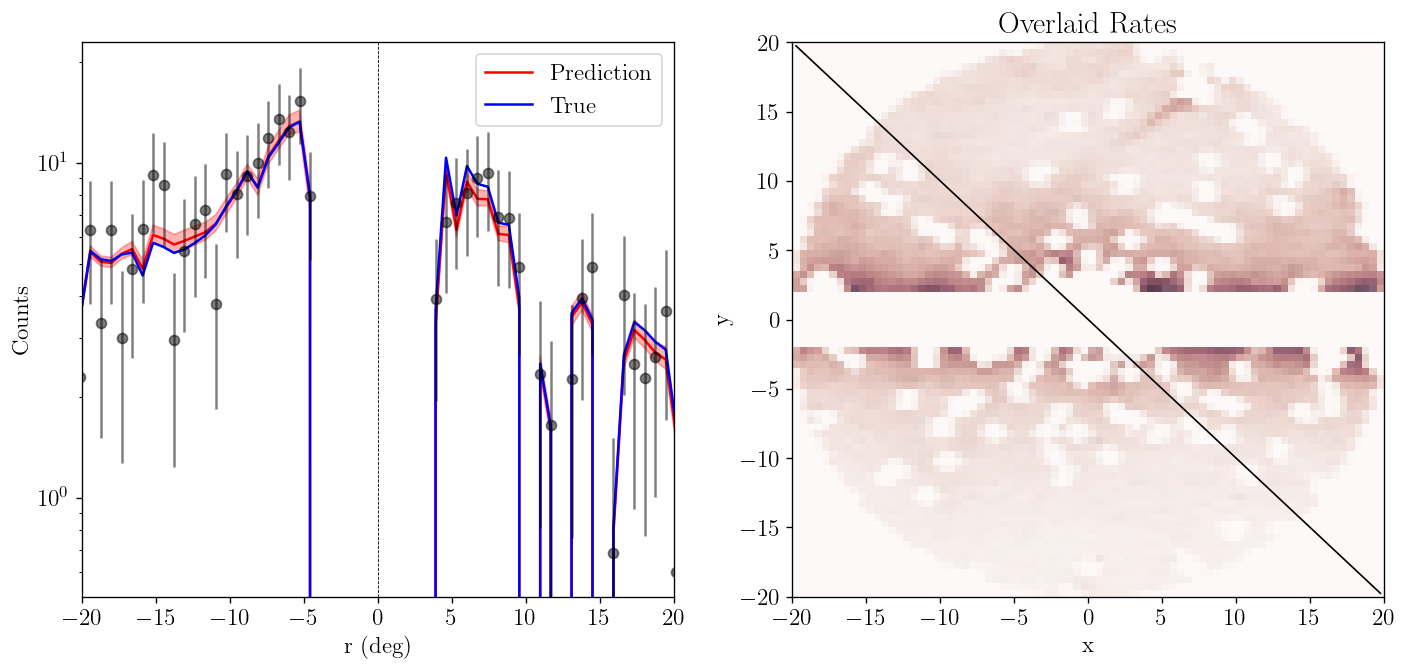

: 

In [109]:
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q_tot, sim_cart, raw_cart, slice_dir = 'horizontal', slice_val = 2., res_scale = 1)
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q_tot, sim_cart, raw_cart, slice_dir = 'vertical', slice_val = 2., res_scale = 1)
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q_tot, sim_cart, raw_cart, slice_dir = 'diagonal_up', slice_val = 2., res_scale = 1)
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q_tot, sim_cart, raw_cart, slice_dir = 'diagonal_down', slice_val = 2., res_scale = 1)

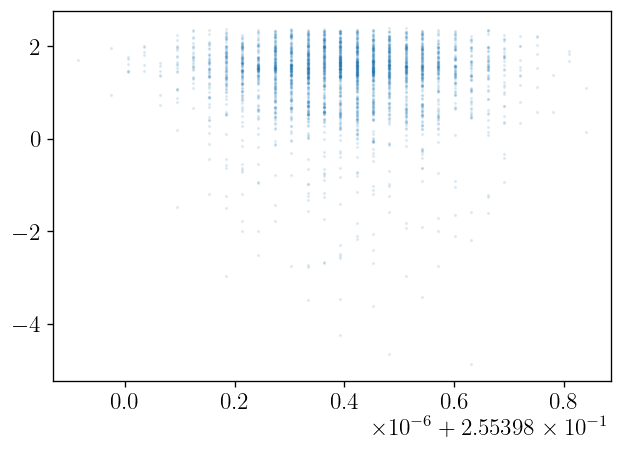

In [25]:
temp_gp = temp_sample_dict['gp']
temp_bub = temp_sample_dict['bub']

temp_sim_nfw_blg = temp_dict['nfw'] + temp_dict['blg']
temp_sim_bub = temp_dict['bub']

temp_gp_mean = np.mean(temp_gp, axis = 0)
temp_gp_std = np.std(temp_gp, axis = 0)

temp_bub_mean = np.mean(temp_bub, axis = 0)
temp_bub_std = np.std(temp_bub, axis = 0)

plt.scatter((temp_bub_mean - temp_sim_bub) / temp_bub_std, (temp_gp_mean - temp_sim_nfw_blg) / temp_gp_std, s = 1, alpha = 0.1)

Text(0, 0.5, '$\\Delta C_{\\mathrm nfw+blg}$')

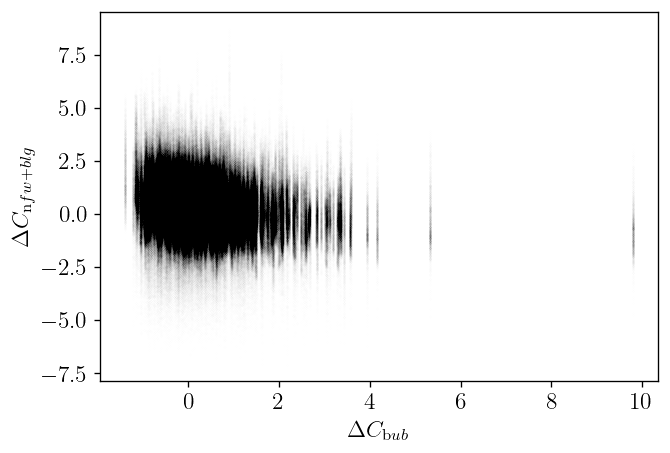

In [26]:
temp_gp = temp_sample_dict['gp']
temp_bub = temp_sample_dict['bub']

temp_sim_nfw_blg = temp_dict['nfw'] + temp_dict['blg']
temp_sim_bub = temp_dict['bub']

temp_gp_mean = np.mean(temp_gp, axis = 0)
temp_gp_std = np.std(temp_gp, axis = 0)

temp_bub_mean = np.mean(temp_bub, axis = 0)
temp_bub_std = np.std(temp_bub, axis = 0)

for n in range(1000):
    plt.scatter((temp_bub[n] - temp_sim_bub) / temp_bub_std, (temp_gp[n] - temp_sim_nfw_blg) / temp_gp_std, c = 'k', s = 0.1, alpha = 0.002)
plt.xlabel('$\Delta C_{\mathrm bub}$')
plt.ylabel('$\Delta C_{\mathrm nfw+blg}$')

Text(0, 0.5, '$\\Delta C_{\\mathrm nfw+blg}$')

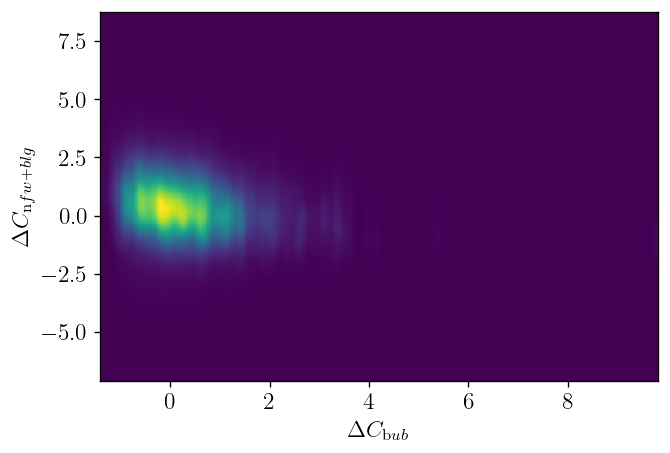

In [27]:
import arviz as az

std_temp_bub = (temp_bub - temp_sim_bub) / temp_bub_std
std_temp_bub = std_temp_bub.reshape((-1,))

std_temp_gp = (temp_gp - temp_sim_nfw_blg) / temp_gp_std
std_temp_gp = std_temp_gp.reshape((-1,))

az.plot_kde(std_temp_bub, std_temp_gp[~np.isnan(std_temp_bub)], contour = False, fill_last = False, plot_kwargs = {'alpha':0.1, 'color':'k'})
plt.xlabel('$\Delta C_{\mathrm bub}$')
plt.ylabel('$\Delta C_{\mathrm nfw+blg}$')
# # plot kde using data




In [19]:
temp_gp = temp_sample_dict['gp']
temp_bub = temp_sample_dict['bub']

temp_sim_nfw_blg = temp_dict['nfw'] + temp_dict['blg']
temp_sim_bub = temp_dict['bub']

temp_gp_mean = np.mean(temp_gp, axis = 0)
temp_gp_std = np.std(temp_gp, axis = 0)

temp_bub_mean = np.mean(temp_bub, axis = 0)
temp_bub_std = np.std(temp_bub, axis = 0)

std_temp_bub = (temp_bub - temp_sim_bub) / temp_bub_std
std_temp_gp = (temp_gp - temp_sim_nfw_blg) / temp_gp_std

std_temp_bub_mean = np.mean(std_temp_bub, axis = 0)
std_temp_gp_mean = np.mean(std_temp_gp, axis = 0)

std_temp_gp_mean_eff = np.array(std_temp_gp_mean)
std_temp_gp_mean_eff[std_temp_gp_mean_eff <= -2.] = 0

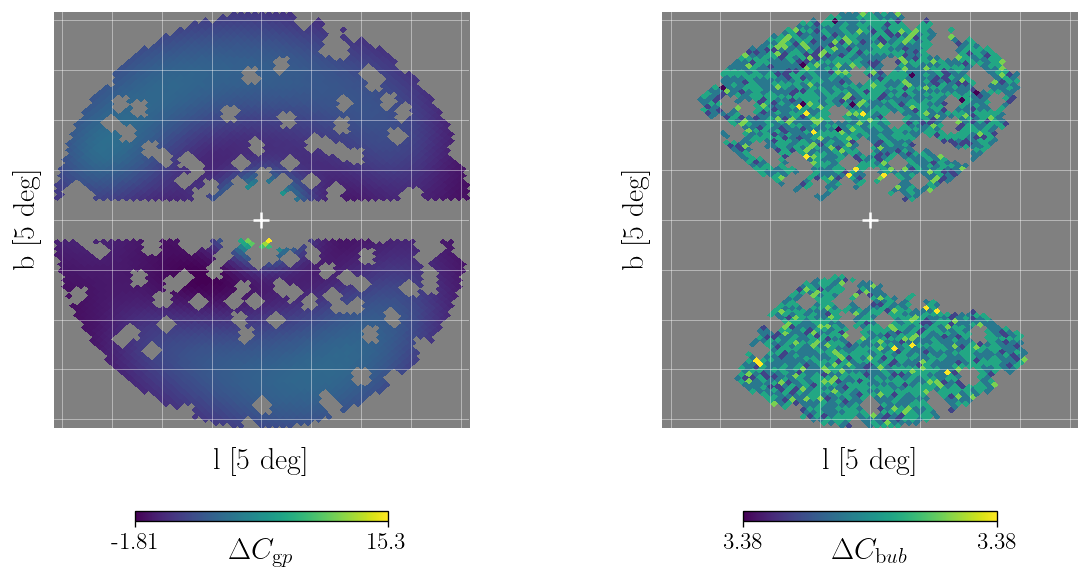

In [20]:
fig = plt.figure(figsize=(12, 6), dpi= 120)
map_p = ef.convert_masked_array_to_hp_array(-(std_temp_gp_mean), mask, log_option = False, nside = 128)
map_bub = ef.convert_masked_array_to_hp_array(std_temp_bub_mean, mask, log_option = False, nside = 128)

ax = fig.add_subplot(1,2,1)
plt.axes(ax)
ef.gnomview_plot(map_p,cbar_title = '$\\Delta C_{\mathrm gp}$')

ax = fig.add_subplot(1,2,2)
plt.axes(ax)
ef.gnomview_plot(map_bub,cbar_title = '$\\Delta C_{\mathrm bub}$')

/data/edr76/gce-prob-prog-ed-v0.2/notebooks/../utils/ed_fcts.py:661: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))
/data/edr76/gce-prob-prog-ed-v0.2/notebooks/../utils/ed_fcts.py:661: RuntimeWarning: invalid value encountered in log10
  hp_map = hp.ma(np.log10(full_array))


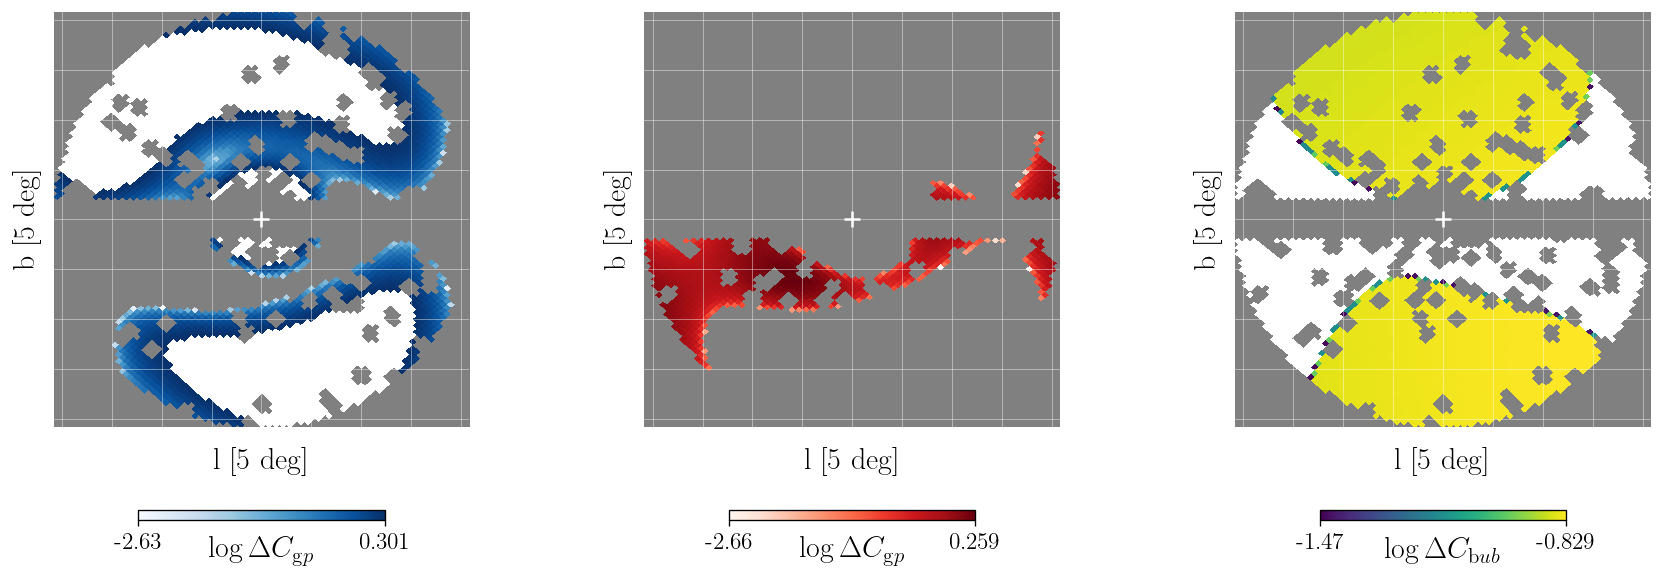

In [21]:
fig = plt.figure(figsize=(18, 6), dpi= 120)
map_p = ef.convert_masked_array_to_hp_array(-(std_temp_gp_mean_eff), mask, log_option = True, nside = 128)
map_p2 = ef.convert_masked_array_to_hp_array((std_temp_gp_mean), mask, log_option = True, nside = 128)
map_bub = ef.convert_masked_array_to_hp_array(temp_dict['bub'], mask, log_option = True, nside = 128)

ax = fig.add_subplot(1,3,1)
plt.axes(ax)
ef.gnomview_plot(map_p,cbar_title = '$\\log \\Delta C_{\mathrm gp}$', cmap = 'Blues')

ax = fig.add_subplot(1,3,2)
plt.axes(ax)
ef.gnomview_plot(map_p2,cbar_title = '$\\log \\Delta C_{\mathrm gp}$', cmap = 'Reds')

ax = fig.add_subplot(1,3,3)
plt.axes(ax)
ef.gnomview_plot(map_bub,cbar_title = '$\\log \\Delta C_{\mathrm bub}$')

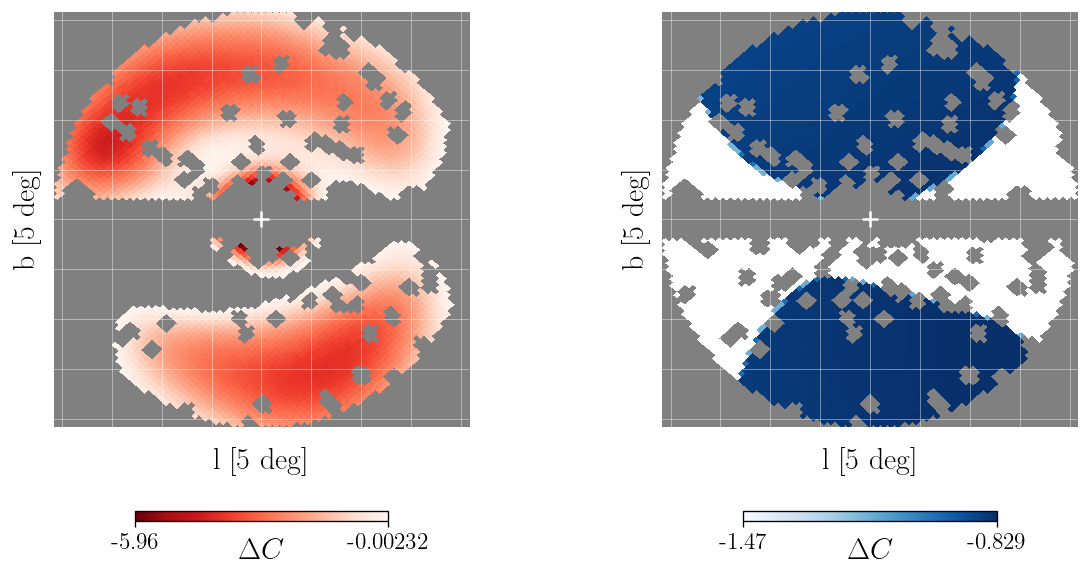

: 

In [50]:
mask_dev = (std_temp_gp_mean <= -6.) | (std_temp_gp_mean >= 0.)

full_array = np.zeros(hp.nside2npix(nside))

# full_array[~mask][~mask_dev] = std_temp_gp_mean[~mask_dev]
full_array_mask = full_array[~mask]
full_array_mask[~mask_dev] = std_temp_gp_mean[~mask_dev]
full_array[~mask] = full_array_mask

mask_tot = np.where(full_array == 0, True, False)

map_p = hp.ma(full_array)
map_p.mask = mask_tot

# map_p = ef.convert_masked_array_to_hp_array(std_temp_gp_mean, mask_tot, log_option = False, nside = 128)
# map_p2 = ef.convert_masked_array_to_hp_array((std_temp_gp_mean), mask_tot, log_option = False, nside = 128)
# map_bub = ef.convert_masked_array_to_hp_array(temp_dict['bub'], mask_tot, log_option = True, nside = 128)

fig = plt.figure(figsize=(12, 6), dpi= 120)
ax = fig.add_subplot(1,2,1)
plt.axes(ax)
ef.gnomview_plot(map_p,cbar_title = '$\\Delta C$', cmap = 'Reds_r')

ax = fig.add_subplot(1,2,2)
plt.axes(ax)
ef.gnomview_plot(map_bub,cbar_title = '$\\Delta C$', cmap = 'Blues')

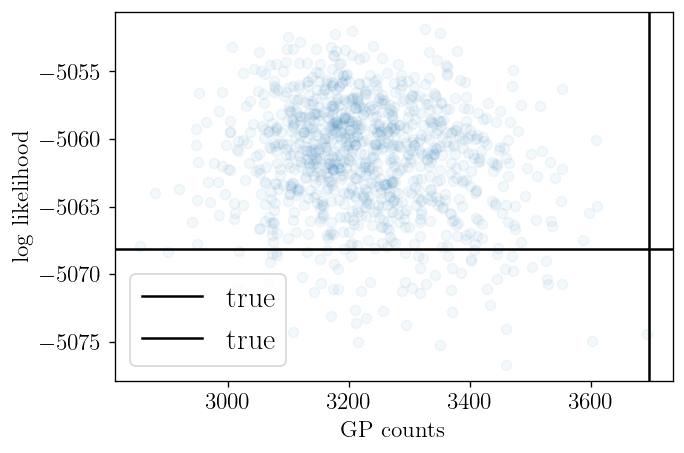

In [36]:
import arviz as az

std_temp_bub = (temp_bub - temp_sim_bub) / temp_bub_std
std_temp_bub = std_temp_bub.reshape((-1,))

std_temp_gp = (temp_gp - temp_sim_nfw_blg) / temp_gp_std
std_temp_gp = std_temp_gp.reshape((-1,))

az.plot_kde(std_temp_bub, std_temp_gp[~np.isnan(std_temp_bub)], contour = False, fill_last = False, plot_kwargs = {'alpha':0.1, 'color':'k'})
plt.xlabel('$\Delta C_{\mathrm bub}$')
plt.ylabel('$\Delta C_{\mathrm nfw+blg}$')
# # plot kde using data